In [15]:
from numcosmo_py import Ncm, Nc, GObject

import numpy as np
import math
import sys
from astropy.io import fits
from astropy.table import Table

%matplotlib inline
import matplotlib.pyplot as plt
import pygtc
import pandas as pd

from richness_mass_calib import create_richness_mass_calib
# #Settings
Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [3]:
# Data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits"
)
dt_halos = Table(DC2_halos_m200c[1].data)
# dt_halos['redshift_true', 'mass_fof', 'm200c', 'richness']
rmdata = create_richness_mass_calib(dt_halos)

ascaso = Nc.ClusterMassAscaso()
lnrich_ext = Nc.ClusterMassLnrichExt()

lnrich_ext.param_set_by_name("mu", 4.60456407051582)
lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)

lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)

lnrich_ext.param_set_by_name("cut", 5.5)
lnrich_ext.param_set_by_name("cutM1", 0.0)
lnrich_ext.param_set_by_name("cutZ1", 0.0)

mset = Ncm.MSet()
mset.set(lnrich_ext)

dset = Ncm.Dataset.new()
dset.append_data(rmdata)
lh = Ncm.Likelihood.new(dset)

mset.param_set_all_ftype(Ncm.ParamType.FREE)
mset.prepare_fparam_map()

fit = Ncm.Fit.new( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL)

fit.log_info()

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  4.60456407051582    [FREE]
#   -    muM1[01]:  0.872079943089853   [FREE]
#   -    muZ1[02]:  1.77432682440775    [FREE]
#   -    muM2[03]:  0.0417736274804596  [FREE]
#   -    muZ2[04]: -0.140721577418961   [FREE]
#   -    muMZ[05]:  0.142254333837774   [FREE]
#   -  sigma0[06]:  0.288099083637692   [FREE]
#   - sigmaM1[07]:  0.01665425603827    [FREE]
#   - sigmaZ1[08]: -0.0170544925340452  [FREE]
#   - sigmaM2[09]:  0.0151710348889877  [FREE]
#   - sigmaZ2[10]:  0.00841242091702829 [FREE]
#   - sigmaMZ[11]:  0.0375086602261856  [FREE]
#   -     cut[12]:  5.5                 [FRE

In [4]:
nwalkers = 2200

Ncm.func_eval_set_max_threads(4)
Ncm.func_eval_log_pool_stats()

init_sampler = Ncm.MSetTransKernGauss.new(0)
init_sampler.set_mset(mset)
init_sampler.set_prior_from_mset()
init_sampler.set_cov_from_rescale(1.0)

apes = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset.fparams_len())

esmcmc = Ncm.FitESMCMC.new(fit, nwalkers, init_sampler, apes, Ncm.FitRunMsgs.SIMPLE)
esmcmc.set_nthreads(4)
esmcmc.set_data_file("ResultsESMCMC/LnrichExt_cutparams_ESMCMC.fits")

# esmcmc.start_run()
# esmcmc.run(2500)  
# esmcmc.end_run()

# NcmThreadPool:Unused:      0
# NcmThreadPool:Max Unused:  2
# NcmThreadPool:Running:     0
# NcmThreadPool:Unprocessed: 0
# NcmThreadPool:Unused:      4


In [5]:
esmcmc.mean_covar()
fit.log_covar()

#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                   ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#      mu[07000:00] =  4.624       +/-  0.0103      |  1           |  0.9115      |  0.1143      |  0.81        | -0.05007     |  0.08776     |  0.2693      |  0.2824      |  0.04823     |  0.2396      | -0.005114    |  0.03349     | -0.3196      | -0.1399      | -0.4559      |
#    muM1[07000:01] =  0.889       +/-  0.007776    |  0.9115      |  1           |  0.3003      |  0.9583      | -0.01948     |  0.2709      |  0.3112      |  0.3178      |  0.02998     |  0.265       |  0.02842     |  0.02635     | -0.3815      | -0.1399      | -0.5061      |
#    muZ1[07000:02] =  1.795       +/-  

In [6]:
fit.log_info()


#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  4.6242757216997     [FREE]
#   -    muM1[01]:  0.889048886264161   [FREE]
#   -    muZ1[02]:  1.79497076479917    [FREE]
#   -    muM2[03]:  0.0450951709800376  [FREE]
#   -    muZ2[04]: -0.138595811451779   [FREE]
#   -    muMZ[05]:  0.149069152028862   [FREE]
#   -  sigma0[06]:  0.292617629679933   [FREE]
#   - sigmaM1[07]:  0.020214679082921   [FREE]
#   - sigmaZ1[08]: -0.0138978042917192  [FREE]
#   - sigmaM2[09]:  0.0158281051864331  [FREE]
#   - sigmaZ2[10]:  0.00863493615093572 [FREE]
#   - sigmaMZ[11]:  0.0384952480360606  [FREE]
#   -     cut[12]:  5.40359407583253    [FRE

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

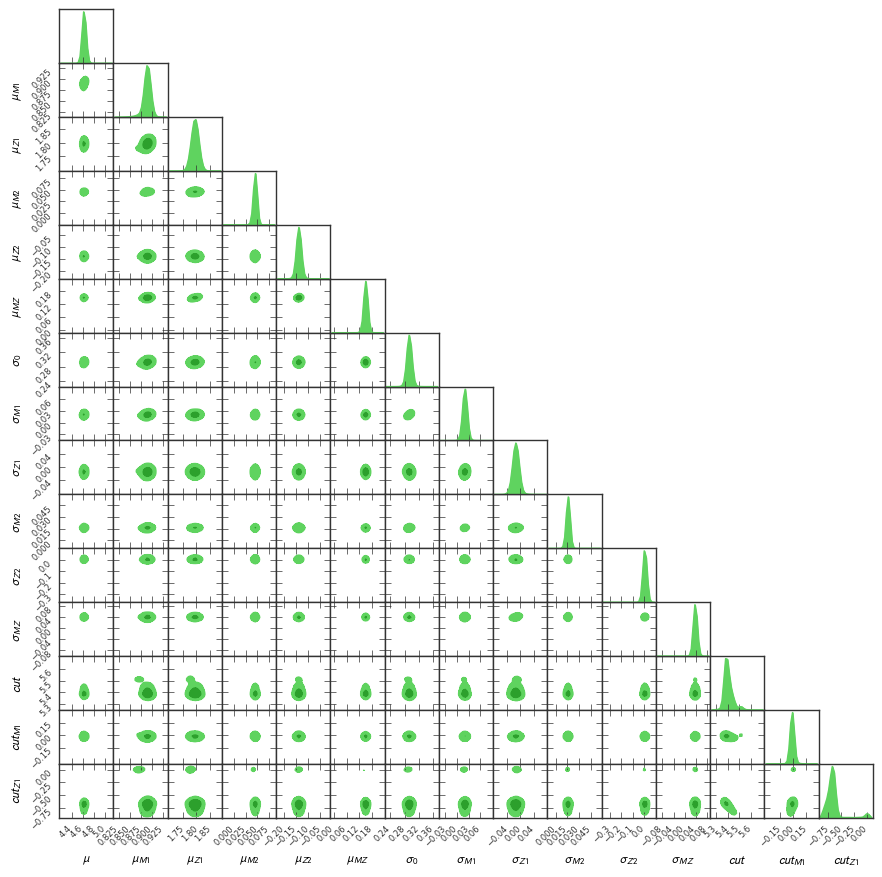

In [38]:
data_fit = pd.DataFrame(fits.open("ResultsESMCMC/LnrichExt_cutparams_ESMCMC.fits")[1].data).loc[:, 'NcClusterMass:mu':'NcClusterMass:cutZ1']

names=["$\mu$", "$\mu_{M1}$", "$\mu_{Z1}$", "$\mu_{M2}$", "$\mu_{Z2}$", "$\mu_{MZ}$", "$\sigma_{0}$", "$\sigma_{M1}$", "$\sigma_{Z1}$", "$\sigma_{M2}$", "$\sigma_{Z2}$", "$\sigma_{MZ}$","$ cut$", "$cut_{M1}$", "$cut_{Z1}$"]

GTC = pygtc.plotGTC(chains=[data_fit], paramNames=names, colorsOrder=['greens'])

